### **1. Introduction & Goal**

**Context**

In the previous notebook (**NB01**), we explored the foundational ideas behind Convolutional Neural Networks (CNNs):
- How convolutional filters extract **edges and textures**.
- How **multi-channel feature maps** combine information from RGB images.
- How **pooling layers** reduce spatial dimensions and introduce invariance.

We worked with **64×64** images in NB01 for simplicity and faster computation.  
In this notebook (**NB02**), we scale up to **128×128** images — capturing finer details while still keeping training feasible.

> **Note:** Moving to larger inputs increases representational power but also raises computational cost — a trade-off worth understanding.

**Goal of This Notebook**

We now transition from **conceptual understanding** to **practical implementation**:
- Build our **first CNN in PyTorch** using layers like `nn.Conv2d`, `nn.ReLU`, `nn.MaxPool2d`, and `nn.Linear`.
- Train and evaluate the model on the **Oxford-IIIT Pets dataset** (37 breeds).
- Visualize predictions and interpret model behavior.


**Learning Objectives**

By the end of this notebook, we will be able to:
1. Implement a CNN with **two convolution layers and two fully connected layers**.
2. Understand the **forward pass** through the network:
   $$
   \text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Pool} \rightarrow 
   \text{Conv} \rightarrow \text{ReLU} \rightarrow \text{Pool} \rightarrow
   \text{Flatten} \rightarrow \text{FC} \rightarrow \text{ReLU} \rightarrow 
   \text{FC} \rightarrow \text{Softmax}
   $$
3. Train and validate the CNN on **128×128 images**.
4. Visualize and interpret predictions on real pet images.

---

**Architecture Overview**

```text
Input (3×128×128)
│
├── Conv2d (3→16) + ReLU + MaxPool
│
├── Conv2d (16→32) + ReLU + MaxPool
│
├── Flatten → Linear (32×32×32 → 128) + ReLU
│
└── Linear (128 → 37) → Softmax
```

This design is simple yet powerful enough to demonstrate CNN fundamentals on Oxford Pets, while remaining computationally manageable.

---


### **2. Dataset Preparation**

**Revisiting the Oxford-IIIT Pets Dataset**

- Dataset: **37 breeds** of cats and dogs (≈7,400 images).
- Each image varies in **size, lighting, and background**.
- Task: **Multiclass classification** (predict breed from image).

In **NB01**, we resized images to **64×64** for quick visualization.  
In this notebook, we upscale to **128×128** for a more realistic training scenario, allowing the CNN to capture finer details.

**Transforms and Normalization**

**1. Resize & ToTensor**

- Convert variable-size images to a fixed **128×128** shape.
- Convert to PyTorch tensors (values in `[0,1]`).

**2. Normalization**

- Normalization centers the data and scales it to unit variance:
  $$
  x' = \frac{x - \mu}{\sigma}
  $$
- For CNNs, we normalize **per channel (R, G, B)** using dataset statistics (mean & std).
- This differs from earlier MLP examples, where we normalized **after flattening** (treating all pixels as one vector).

**Data Splits**

- The Oxford Pets dataset provides **`trainval`** and **`test`** splits.
- We will:
  - Use `trainval` for **training & validation** (split internally).
  - Use `test` for **final evaluation**.

**What We’ll Do in Code**

1. Define transforms: `Resize → ToTensor → Normalize`.  
2. Load train and test sets with `torchvision.datasets.OxfordIIITPet`.  
3. Inspect dataset properties (size, class names).  
4. Visualize a **batch of 128×128 images** with their labels.

**Load and Visualize Dataset**

Train size: 2944
Validation size: 736
Test size: 3669
Number of classes: 37
Example classes: ['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle']


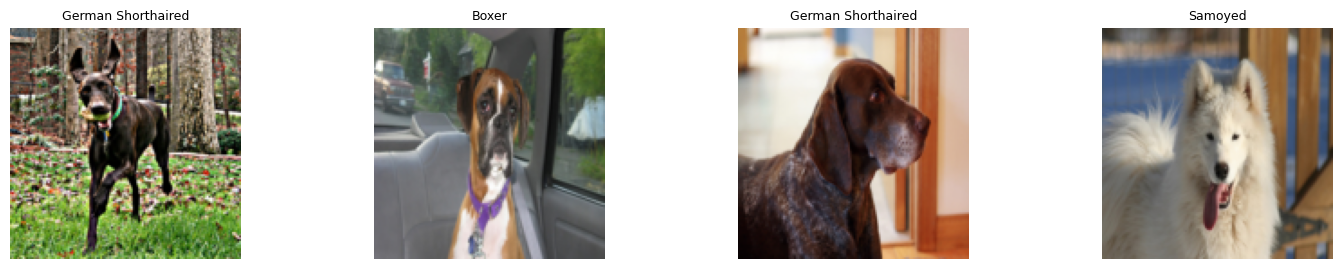

In [1]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# 1. Define data path and transforms
# -----------------------------
data_path = "./data/oxford-iiit-pet"

# Image size for this notebook
IMG_SIZE = 128

# Transform: Resize → ToTensor → Normalize
# Note: Mean/std values are approximations; for production, compute from dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # scale to [-1,1]
])

# -----------------------------
# 2. Load datasets
# -----------------------------
# Trainval split (to be further split into train/val)
trainval_dataset = datasets.OxfordIIITPet(
    root="./data/",
    split="trainval",
    target_types="category",
    transform=transform,
    download=True
)

# Test set
test_dataset = datasets.OxfordIIITPet(
    root="./data/",
    split="test",
    target_types="category",
    transform=transform,
    download=True
)

# -----------------------------
# 3. Train/Validation Split
# -----------------------------
val_ratio = 0.2
train_size = int((1 - val_ratio) * len(trainval_dataset))
val_size = len(trainval_dataset) - train_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

# -----------------------------
# 4. DataLoaders
# -----------------------------
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -----------------------------
# 5. Inspect dataset properties
# -----------------------------
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Number of classes: {len(trainval_dataset.classes)}")
print(f"Example classes: {trainval_dataset.classes[:5]}")

# -----------------------------
# 6. Visualize a batch
# -----------------------------
def show_batch(loader, classes, n=4):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize=(18, 3))
    for i in range(n):
        img = images[i] * 0.5 + 0.5  # unnormalize to [0,1] for display
        axes[i].imshow(np.transpose(img.numpy(), (1, 2, 0)))
        axes[i].set_title(classes[labels[i]], fontsize=9)
        axes[i].axis("off")
    plt.show()

show_batch(train_loader, trainval_dataset.classes)


---

---

### **3. CNN Architecture Design (Conceptual)**

**Baseline CNN Structure**

We will design a **simple yet powerful CNN** to classify the 37 pet breeds:

- **2 Convolution Layers** (extract low- and mid-level features)
- **ReLU Activation** (introduce non-linearity)
- **Max Pooling** (downsample feature maps)
- **Flatten Layer** (convert 3D feature maps to 1D vector)
- **2 Fully Connected Layers (FC)** (combine features for classification)
- **Output Layer (Softmax)** (37-class probability distribution)

**Architecture Overview (ASCII)**

```text
Input: 3 × 128 × 128
│
├── Conv1: 16 filters (3×3) → ReLU → MaxPool (2×2)
│
├── Conv2: 32 filters (3×3) → ReLU → MaxPool (2×2)
│
├── Flatten → FC1 (128 units) → ReLU
│
└── FC2 (37 units) → Softmax
```

**Assumptions for Shape Calculations**

- **Kernel size:** $3 \times 3$ (both Conv layers)  
- **Padding:** $1$ (keeps spatial size same after convolution)  
- **Stride (Conv):** $1$  
- **Pooling:** $2 \times 2$ max pooling (halves spatial dimensions)  

**Formula for Convolution Output Size**

For an input with spatial dimension $H \times W$:

$$
H_{out} = \frac{H + 2P - K}{S} + 1, \qquad
W_{out} = \frac{W + 2P - K}{S} + 1
$$

Where:
- $K$ = kernel size
- $P$ = padding
- $S$ = stride

For pooling ($2 \times 2$, stride 2):

$$
H_{out} = \frac{H}{2}, \qquad W_{out} = \frac{W}{2}
$$


**Shape Transformations (Step-by-Step)**

| Layer                           | Input Shape    | Output Shape   | Operation Details                    |
| ------------------------------- | -------------- | -------------- | ------------------------------------ |
| **Input**                       | $3 \times 128 \times 128$  | $3 \times 128 \times 128$  | Raw RGB image                        |
| **Conv1 (3→16, k=3,p=1,s=1)**   | $3 \times 128 \times 128$  | $16 \times 128 \times 128$ | Computed using formula: $128 = \frac{128 + 2(1) - 3}{1} + 1$ |
| **MaxPool1 (2×2)**              | $16 \times 128 \times 128$ | $16 \times 64 \times 64$   | Downsample: $128 / 2 = 64$           |
| **Conv2 (16→32, k=3,p=1,s=1)**  | $16 \times 64 \times 64$   | $32 \times 64 \times 64$   | Computed similarly with padding 1    |
| **MaxPool2 (2×2)**              | $32 \times 64 \times 64$   | $32 \times 32 \times 32$   | Downsample: $64 / 2 = 32$            |
| **Flatten**                     | $32 \times 32 \times 32$   | $32,768$                     | Convert 3D tensor to 1D vector       |
| **FC1 (32,768→128)**            | $32,768$                     | $128$                        | Combine features, apply ReLU         |
| **FC2 (128→37)**                | $128$                        | $37$                         | Class logits for 37 breeds           |

<br>

> **Why This Architecture?**

**Progressive Feature Learning**
- **First Conv layer:** captures edges and colors.
- **Second Conv layer:** captures textures and patterns (e.g., fur details).

**Pooling Layers**
- Reduce computational cost and add translation invariance.

**Fully Connected Layers**
- Integrate high-level features for final classification.


> **CNN vs MLP (from Project 4)**

- **MLP:** Flattens input immediately → loses spatial information.  
- **CNN:** Preserves spatial structure → fewer parameters (weight sharing).

**Parameter Comparison (approx.)**

- **MLP on $128 \times 128$:** ~6M parameters (fully connected from start).  
- **CNN (2 conv layers + FC):** ~4M parameters, yet higher accuracy due to spatial features.




---

### **4. Implementing the CNN (PyTorch Code)**

**From Concept to Code**

We now translate our conceptual architecture into PyTorch:

- **Class-based model (`nn.Module`)**: Main approach — flexible, industry standard, good for learning `forward()` flow.
- **Sequential alternative (`nn.Sequential`)**: Concise version for straightforward feedforward networks.

**Parameter Awareness**

CNNs are **parameter-efficient** because:
- Convolutional filters are **shared across spatial locations** (few parameters).
- Fully connected layers dominate parameter count in small CNNs.

Example (128×128 input):
- After 2 conv + pool layers → feature map is `32×32×32 = 32,768` features.
- FC1 reduces `32,768 → 128` (≈ 4.2M params) — still far fewer than a pure MLP (~6M params).

We’ll print parameter counts to highlight this efficiency.


**Define CNN Model - Class-Based Implementation**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Ensure reproducibility
torch.manual_seed(42)

class PetCNN(nn.Module):
    def __init__(self):
        super(PetCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)  # Input: 3x128x128 → 16x128x128
        self.pool = nn.MaxPool2d(2, 2)                                                   # Downsample → 16x64x64
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1) # 16x64x64 → 32x64x64
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 32 * 32, 128)   # Flatten: 32x32x32 → 128
        self.fc2 = nn.Linear(128, 37)             # 37 classes (pet breeds)

    def forward(self, x):
        # Input: 3 x 128 x 128
        x = self.pool(F.relu(self.conv1(x)))   # After Conv1+ReLU+Pool → 16 x 64 x 64
        x = self.pool(F.relu(self.conv2(x)))   # After Conv2+ReLU+Pool → 32 x 32 x 32
        x = x.view(-1, 32 * 32 * 32)           # Flatten → 32768
        x = F.relu(self.fc1(x))                # FC1 + ReLU → 128
        x = self.fc2(x)                        # FC2 (logits) → 37
        return x

# Instantiate and print model
model = PetCNN()
print(model)

PetCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=37, bias=True)
)


**Parameter Count Function**

In [5]:
def count_parameters_by_type(model):
    # Total trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # Convolutional layers
    conv_params = sum(p.numel() for m in model.modules() if isinstance(m, nn.Conv2d) 
                      for p in m.parameters())
    
    # Fully connected (Linear) layers
    fc_params = sum(p.numel() for m in model.modules() if isinstance(m, nn.Linear) 
                    for p in m.parameters())
    
    print(f"Total trainable parameters: {total_params:,}")
    print(f" - Convolutional layers: {conv_params:,}")
    print(f" - Fully connected layers: {fc_params:,}")


count_parameters_by_type(model)

Total trainable parameters: 4,204,293
 - Convolutional layers: 5,088
 - Fully connected layers: 4,199,205


**Alternative: `nn.Sequential` Implementation**

For simple feedforward architectures, we can define the same model using `nn.Sequential`:

- Pros: Very concise, readable.
- Cons: Limited flexibility — cannot handle skip connections or complex flows.

(We’ll stick to **class-based** for training, but this gives students an extra perspective.)


**Define CNN Model - Sequential Implementation**

In [6]:
model_seq = nn.Sequential(
    nn.Conv2d(3, 16, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, 3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(32 * 32 * 32, 128),
    nn.ReLU(),
    nn.Linear(128, 37)
)

print(model_seq)
count_parameters_by_type(model_seq)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=32768, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=37, bias=True)
)
Total trainable parameters: 4,204,293
 - Convolutional layers: 5,088
 - Fully connected layers: 4,199,205


**Reflection**

- Both implementations (Class-based and Sequential) produce **identical architectures**.
- **Parameter efficiency:** CNNs use **fewer parameters than an equivalent MLP**:
  - Convolutions share weights across the image (fewer unique parameters).
  - Pooling reduces spatial dimensions, shrinking FC layers dramatically.
- In Project 4, we saw MLPs explode in parameter count when scaling to larger images;  
  here, even at **128×128**, our CNN stays manageable (~4M params).

> Key takeaway: CNNs scale better to high-resolution inputs — crucial for real-world images.


**CNN vs MLP Parameter Count ($128\times128$ Input)**

Let’s estimate parameter counts if we built an **MLP** instead of this CNN:

- MLP scenario (eg., Input -> FC -> FC -> Output)

    - **Input size** = $3 \times 128 \times 128 = 49,152$ features  
    - **First FC layer (49,152 → 256 units):**

    $$
    49,152 \times 256 + 256 \approx 12.6\ \text{million parameters}
    $$

    - Fully connected layers dominate the model size.

- CNN scenario (this notebook)

    - After two Conv+Pool blocks:

    $$
    32 \times 32 \times 32 = 32,768 \text{ features}
    $$

    - **FC1 (32,768 → 128 units):**

    $$
    32,768 \times 128 + 128 \approx 4.2\ \text{million parameters}
    $$

    - Conv layers add only $\sim 13K$ parameters (tiny compared to FC).

        ```text
        MLP: 49,152 ──► FC ──► FC ──► Output (≈12M params)

        CNN: 3×128×128 ──► Conv+Pool ──► Conv+Pool ──► FC ──► Output (≈4M params)
        ```

- CNN is $\sim 3\times$ smaller in parameters while capturing **spatial patterns**.  
- This efficiency allows CNNs to handle **larger inputs** (e.g., $224\times224$ in ImageNet) without massive memory costs.

---


### **5. Loss Function & Optimizer**

**Why Cross-Entropy Loss?**

- Our task is **multiclass classification** (37 pet breeds).  
- We need a loss function that:
  - Compares predicted **class probabilities** with **true labels**.
  - Encourages high probability for the correct class and low for others.

**Cross-Entropy Formula:**

$$
\text{Loss} = - \sum_{c=1}^{C} y_c \log(\hat{p}_c)
$$

Where:
- $ y_c $ = 1 for correct class, 0 otherwise (one-hot target).
- $ \hat{p}_c $ = predicted probability for class $ c $.

**Important Detail (Softmax + Logits)**

- **`nn.CrossEntropyLoss` in PyTorch:**
  - Expects **raw logits** (no softmax applied manually).
  - Internally applies `LogSoftmax` + `NLLLoss`.
  - More **numerically stable** than applying `Softmax` separately.


**Flow: Logits → Probabilities → Loss**

```text
Model Output (logits) ──► Softmax ──► Probabilities ──► Compare with Target ──► Cross-Entropy Loss
```

**Optimizer Choice**

- We’ll start with **Adam**:
  - Adaptive learning rate → good for quick convergence.
  - Handles sparse gradients (common in images).

- Alternative: **SGD + momentum**
  - Often used in large-scale training (e.g., ImageNet).
  - Can generalize slightly better but needs careful LR tuning.


**Learning Rate Note**

- Initial LR = `1e-3` (good default for Adam).  
- We may adjust later (e.g., LR scheduler) if loss plateaus or oscillates.

**Code Cell – Define Loss and Optimizer**

In [7]:
import torch.optim as optim

# Define loss function (CrossEntropyLoss handles Softmax internally)
criterion = nn.CrossEntropyLoss()

# Define optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("Loss Function:", criterion)
print("Optimizer:", optimizer)


Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


**Reflection**

- Cross-Entropy Loss fits **multiclass classification** naturally.
- Feeding **logits directly** (no softmax) avoids redundant computation and improves stability.
- Adam is a practical starting optimizer; we can later experiment with **SGD + momentum** or learning rate schedules.

---

### **6. Training the CNN**

**Training Process Overview**

We train our baseline CNN using a standard loop:

1. **Epoch iteration:**
   - **Training phase:** forward pass → loss → backward pass → optimizer step.
   - **Validation phase:** evaluate on held-out validation data (no gradient updates).

2. **Metrics tracked:**
   - Training & validation **loss** per epoch.
   - Training & validation **accuracy** per epoch.
   - **Best model checkpoint** saved (lowest validation loss).

**Key Implementation Details**

- **Mode switching:**  
  - `model.train()` during training (activates dropout/batch norm if present).  
  - `model.eval()` during validation (disables gradient updates).

- **Checkpoint saving:**  
  - Save best weights when validation loss improves.  
  - Prevents overfitting from later epochs overwriting good weights.

- **Visualization:**  
  - Plot training/validation loss and accuracy curves after training completes.

**Training Utilities**

In [8]:
import time
import copy

# Accuracy calculation helper
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / len(labels)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device='cpu'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has train and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data
            for inputs, labels in loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Backward + optimize in train phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (outputs.argmax(1) == labels).sum().item()
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)

                # Deep copy the model if validation improves
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Time tracking
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best val loss: {best_loss:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Save checkpoint
    torch.save(model.state_dict(), "petcnn_best.pth")

    return model, (train_losses, val_losses, train_accuracies, val_accuracies)


**Run Training**

In [9]:
# Example: Train for 5 epochs (CPU-only)
device = 'cpu'  # Force CPU for consistency across all project notebooks
model, history = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, device=device)

Epoch 1/5
--------------------
Train Loss: 3.5931 Acc: 0.0445
Val Loss: 3.5048 Acc: 0.0584
Epoch 2/5
--------------------
Train Loss: 3.2790 Acc: 0.1128
Val Loss: 3.3068 Acc: 0.0978
Epoch 3/5
--------------------
Train Loss: 2.8471 Acc: 0.2204
Val Loss: 3.1985 Acc: 0.1277
Epoch 4/5
--------------------
Train Loss: 2.0987 Acc: 0.4103
Val Loss: 3.5407 Acc: 0.1413
Epoch 5/5
--------------------
Train Loss: 1.0277 Acc: 0.7245
Val Loss: 4.2938 Acc: 0.1155
Training complete in 5m 4s
Best val loss: 3.1985


**Plot Loss and Accuracy Curves**

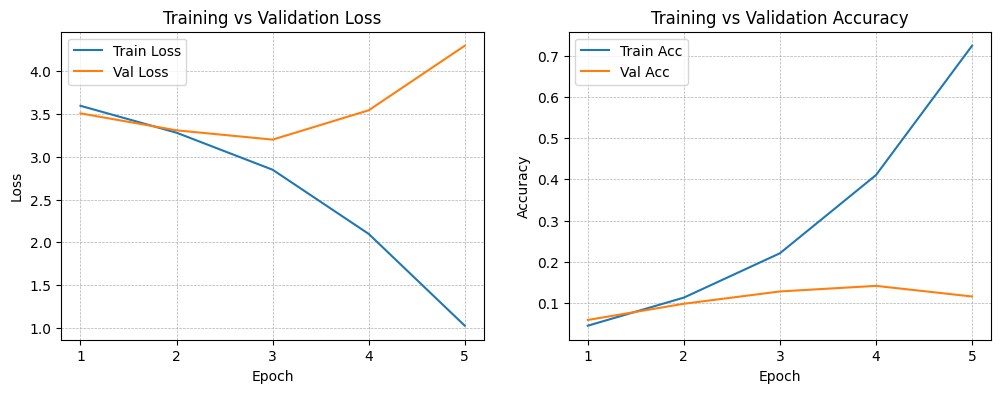

In [10]:
# Plot training curves
train_losses, val_losses, train_acc, val_acc = history

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12,4))

# Loss plot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xticks(epochs)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.xticks(epochs)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.show()


**Quick Observation**

- Training loss is **decreasing sharply**, but validation loss is **rising after epoch 3**.  
- Training accuracy climbs steadily (70%+), while validation accuracy **plateaus near 12–15%**.

**What does this mean?**
- The model is **overfitting**: it memorizes training data but fails to generalize to unseen validation data.
- This is expected for our **baseline CNN** — it’s intentionally simple and lacks regularization or augmentation.

---

### **7. Summary & Transition**

**What We Achieved in NB02**

- Implemented and trained our **first CNN** on the Oxford-IIIT Pets dataset:
  - Scaled up from **64×64 toy images (NB01)** to **128×128 real images**.
  - Designed a **2-conv + 2-FC** architecture and trained it end-to-end.
  - Tracked **training vs validation loss/accuracy** to monitor learning progress.

- Observed key trends:
  - **Training accuracy** rises quickly (~70%+), but **validation accuracy** stalls (~12–15%).
  - **Overfitting** occurs early — validation loss diverges from training loss.

**Why This Matters**

- This **baseline performance** provides a reference point:
  - Confirms CNNs are more **parameter-efficient** than MLPs (weight sharing, spatial locality).
  - Reveals limitations of a shallow CNN on **37-class classification** (needs richer features + regularization).

**Next Steps: NB03 (Evaluation & Error Analysis)**

- In the next notebook, we **don’t change the architecture yet**.  
- Instead, we focus on **evaluating the baseline thoroughly**:
  - Confusion matrix and **per-class metrics** (precision, recall, F1).  
  - Visual inspection of **correct vs misclassified samples**.  
  - Identifying **systematic biases or recurring failure modes** (e.g., similar breeds).

---